In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
df_sales = pd.read_csv('sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

df_shops = pd.read_csv('shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})

df_items = pd.read_csv('items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})

df_item_categories = pd.read_csv('item_categories.csv', dtype={'item_category_name': 'str', 'item_category_id': 'int32'})

df_test = pd.read_csv('test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                    'item_id': 'int32'})

In [3]:
df_train = df_sales.join(df_items, on = 'item_id', rsuffix = '_').join(df_shops, on = 'shop_id', rsuffix = '_').join(df_item_categories, on = 'item_category_id', rsuffix = '_')

In [4]:
df_train = df_train.drop(['item_id_', 'shop_id_', 'item_category_id_'], axis = 1)

In [5]:
df_train.shape

(2935849, 10)

In [6]:
df_train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
5,2013-10-01,0,25,2564,349.00,1,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,"Москва ТРК ""Атриум""",Музыка - Музыкальное видео
6,2013-02-01,0,25,2565,549.00,1,DEEP PURPLE Stormbringer (фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
7,2013-04-01,0,25,2572,239.00,1,DEFTONES Koi No Yokan,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
8,2013-11-01,0,25,2572,299.00,1,DEFTONES Koi No Yokan,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
9,2013-03-01,0,25,2573,299.00,3,DEL REY LANA Born To Die,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства


In [7]:
df_train.nunique()

date                   1034
date_block_num           34
shop_id                  60
item_id               21807
item_price            19992
item_cnt_day            198
item_name             21807
item_category_id         84
shop_name                60
item_category_name       84
dtype: int64

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int32         
 2   shop_id             int32         
 3   item_id             int32         
 4   item_price          float32       
 5   item_cnt_day        int32         
 6   item_name           object        
 7   item_category_id    int32         
 8   shop_name           object        
 9   item_category_name  object        
dtypes: datetime64[ns](1), float32(1), int32(5), object(3)
memory usage: 156.8+ MB


In [9]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [10]:
print('Min date from train set: %s' % df_train['date'].min().date())
print('Max date from train set: %s' % df_train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


Data Leakage (comparing items and shops in test and train dfs)

In [11]:
df_test_shops = df_test['shop_id'].unique()
df_test_items = df_test['item_id'].unique()
df_train_lk = df_train[df_train['shop_id'].isin(df_test_shops)]
df_train_lk = df_train_lk[df_train_lk['item_id'].isin(df_test_items)]

In [12]:
df_train.shape, df_train_lk.shape

((2935849, 10), (1224439, 10))

In [13]:
df_train_lk = df_train_lk.query('item_price > 0')

In [14]:
df_train_lk.shape

(1224439, 10)

Preprocessing

removing unwanted columns and aggregating data by month (task to predict sales in the next month)

In [15]:
df_train_month = df_train_lk[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

df_train_month = df_train_month.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)

df_train_month = df_train_month.agg({'item_price':['sum', 'mean'], 'item_cnt_day': ['sum', 'mean', 'count']})

In [16]:
df_train_month.head(10)

date_block_num shop_id item_category_id item_id item_price          \
                                                         sum    mean   
0              0       2                2    5572   10730.00 1532.86   
1              0       2                2    5643    4775.21 2387.60   
2              0       2                5    5583    1188.30  594.15   
3              0       2                6    7893    5970.00 1990.00   
4              0       2                6    7894    1490.00 1490.00   
5              0       2                6    7895    2697.00  899.00   
6              0       2                6    7956   13780.00 6890.00   
7              0       2               19    1409    1398.50 1398.50   
8              0       2               19    1467     899.00  899.00   
9              0       2               19    3076    1399.00 1399.00   

  item_cnt_day             
           sum mean count  
0            9 1.29     7  
1            0 0.00     2  
2            2 1.00     2  
3            3 1.00     3  
4            1 1.00     1  
5            4 1.33     3  
6            2 1.00     2  
7            1 1.00     1  
8            1 1.00     1  
9            1 1.00     1

In [17]:
df_train_month.columns = ['month', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [18]:
df_train_month.head(10)

,month,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.00,1532.86,9,1.29,7
1,0,2,2,5643,4775.21,2387.60,0,0.00,2
2,0,2,5,5583,1188.30,594.15,2,1.00,2
3,0,2,6,7893,5970.00,1990.00,3,1.00,3
4,0,2,6,7894,1490.00,1490.00,1,1.00,1
5,0,2,6,7895,2697.00,899.00,4,1.33,3
6,0,2,6,7956,13780.00,6890.00,2,1.00,2
7,0,2,19,1409,1398.50,1398.50,1,1.00,1
8,0,2,19,1467,899.00,899.00,1,1.00,1
9,0,2,19,3076,1399.00,1399.00,1,1.00,1


creating "missing" df - no records = 0 in the purchases

In [19]:
shop_ids = df_train_month['shop_id'].unique()
item_ids = df_train_month['item_id'].unique()
missing_records_list = []

for i in range(34): #we have 34 months
    for shop_id in shop_ids:
        for item_id in item_ids:
            missing_records_list.append([i, shop_id, item_id])
            
df_missing = pd.DataFrame(missing_records_list, columns = ['month', 'shop_id', 'item_id'])

In [20]:
df_train_month_w_missing = pd.merge(df_missing, df_train_month, on = ['month', 'shop_id', 'item_id'], how = 'left')
df_train_month_w_missing.fillna(0, inplace= True)


In [21]:
df_train_month_w_missing['year'] = df_train_month_w_missing['month'].apply(lambda x: ((x//12)+2013))
df_train_month_w_missing['monthly'] = df_train_month_w_missing['month'].apply(lambda x: (x%12))

Exploratory data analysis

In [22]:
#grouping data
g_month_mean = df_train_month_w_missing.groupby(['monthly'], as_index = False)['item_cnt'].mean()
g_month_sum = df_train_month_w_missing.groupby(['monthly'], as_index = False)['item_cnt'].sum()
g_item_category_mean = df_train_month_w_missing.groupby(['item_category_id'], as_index = False)['item_cnt'].mean()
g_item_category_sum = df_train_month_w_missing.groupby(['item_category_id'], as_index = False)['item_cnt'].sum()
g_shop_mean = df_train_month_w_missing.groupby(['shop_id'], as_index = False)['item_cnt'].mean()
g_shop_sum = df_train_month_w_missing.groupby(['shop_id'], as_index = False)['item_cnt'].sum()

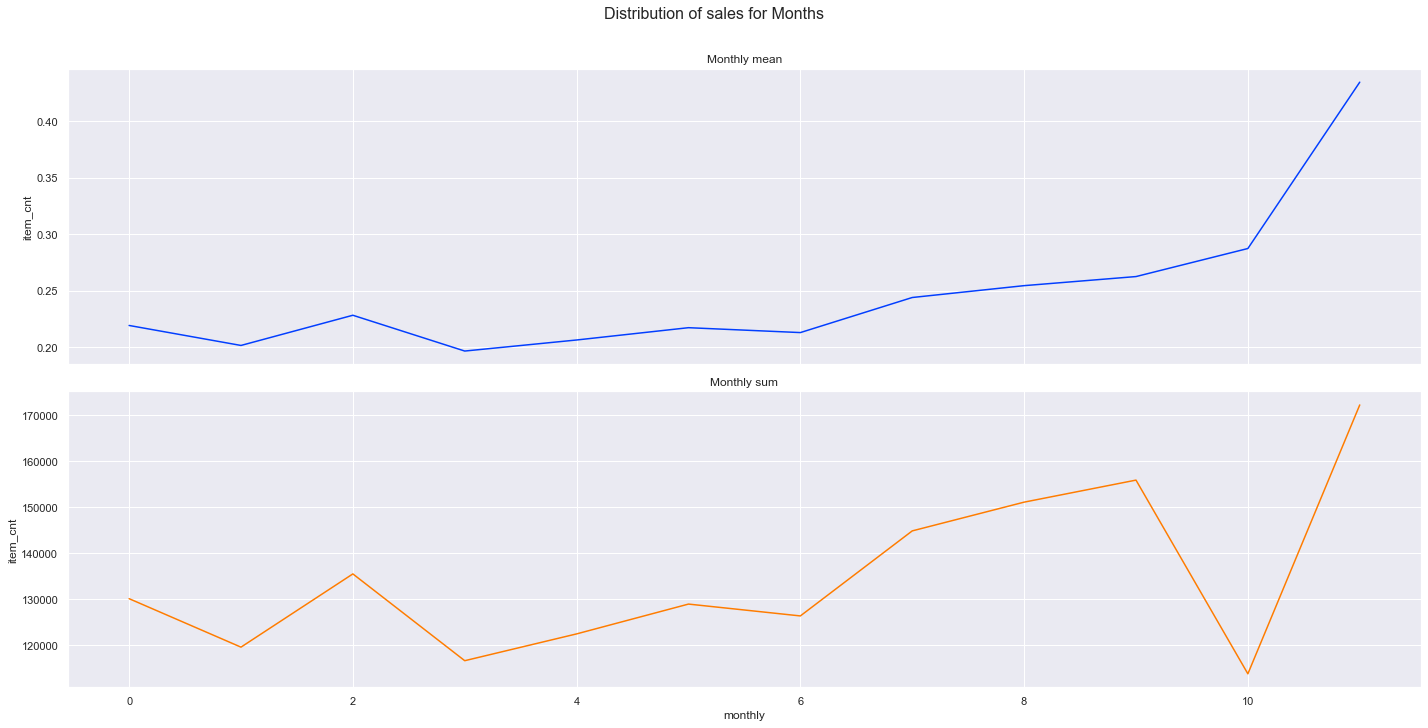

In [23]:
#sales by month, shop, category
sns.set(color_codes = True)
colors = sns.color_palette("bright")

fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
sns.lineplot(x="monthly", y="item_cnt", data=g_month_mean, ax=axes[0],  color = colors[0]).set_title("Monthly mean")
sns.lineplot(x="monthly", y="item_cnt", data=g_month_sum, ax=axes[1], color = colors[1]).set_title("Monthly sum")
plt.suptitle("Distribution of sales for Months", y=1.01, size = 16)
plt.tight_layout()
plt.show()



By the end of the year numbers are increasing

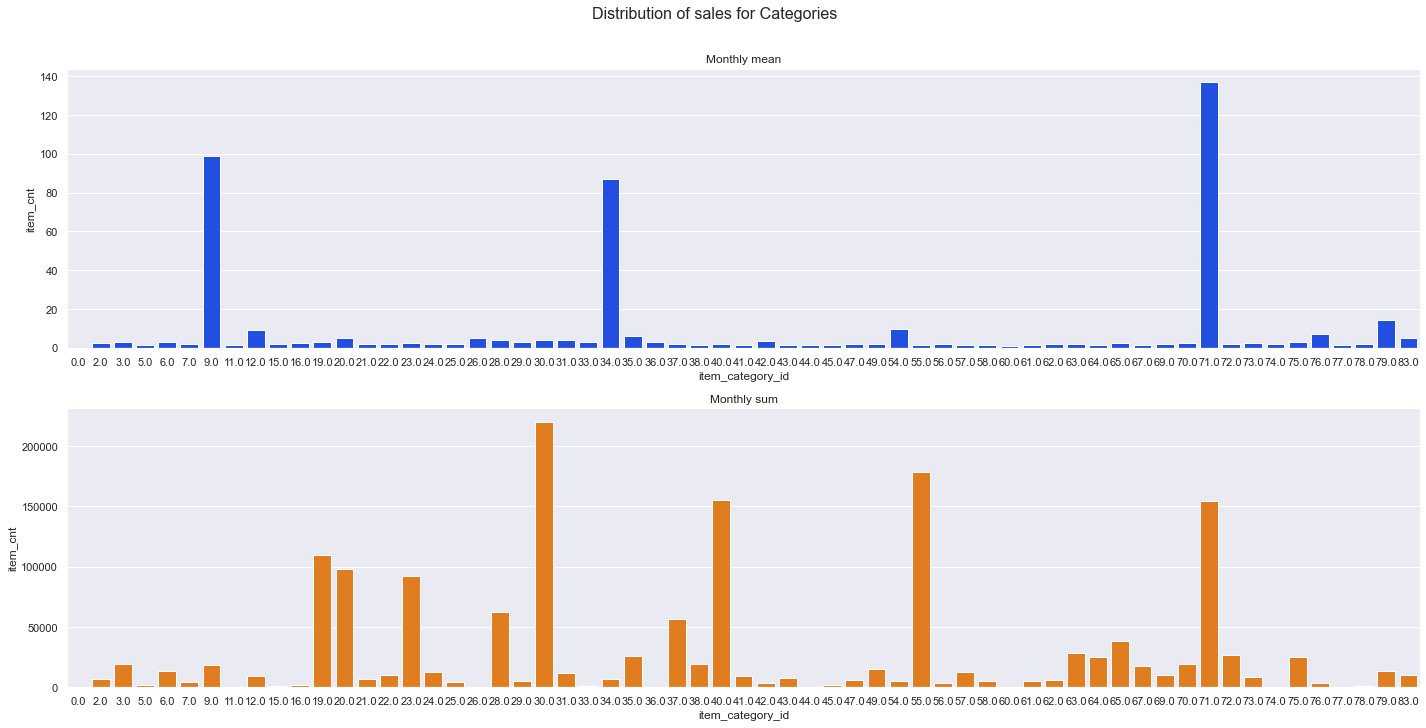

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
sns.barplot(x="item_category_id", y="item_cnt", data=g_item_category_mean, ax=axes[0],  color = colors[0]).set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=g_item_category_sum, ax=axes[1], color = colors[1]).set_title("Monthly sum")
plt.suptitle("Distribution of sales for Categories", y=1.01, size = 16)
plt.tight_layout()
plt.show()

Some categories outline in comparison with others

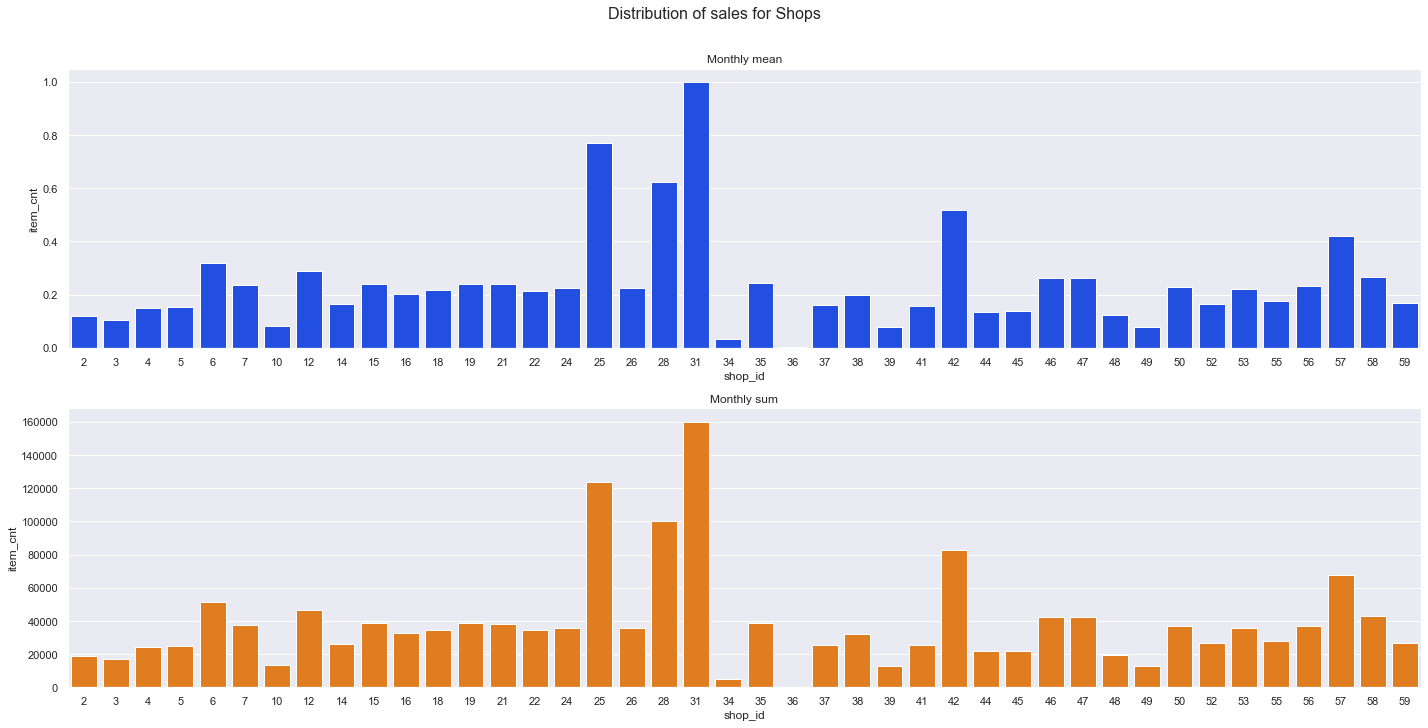

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
sns.barplot(x="shop_id", y="item_cnt", data=g_shop_mean, ax=axes[0],  color = colors[0]).set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=g_shop_sum, ax=axes[1], color = colors[1]).set_title("Monthly sum")
plt.suptitle("Distribution of sales for Shops", y=1.01, size = 16)
plt.tight_layout()
plt.show()

3 shops (25, 26, 31) maybe large stores 

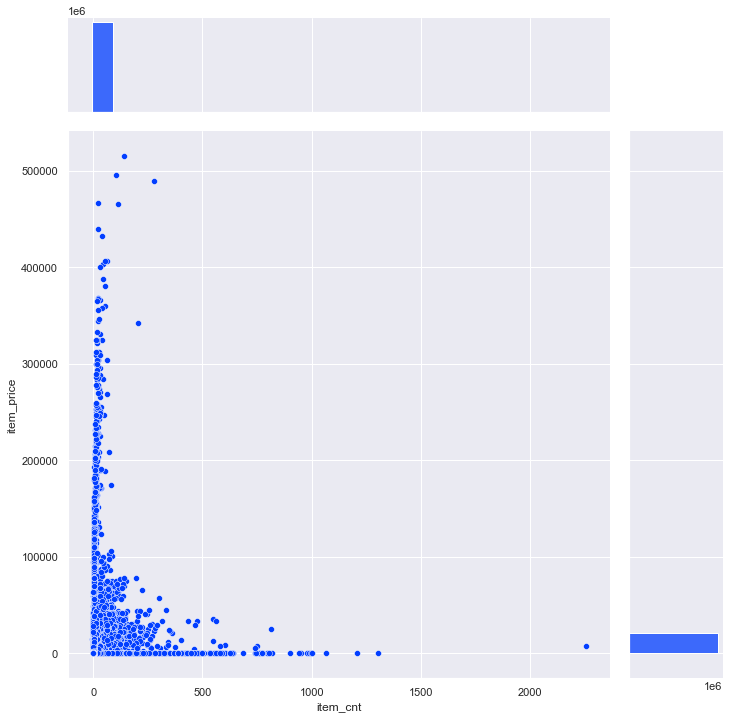

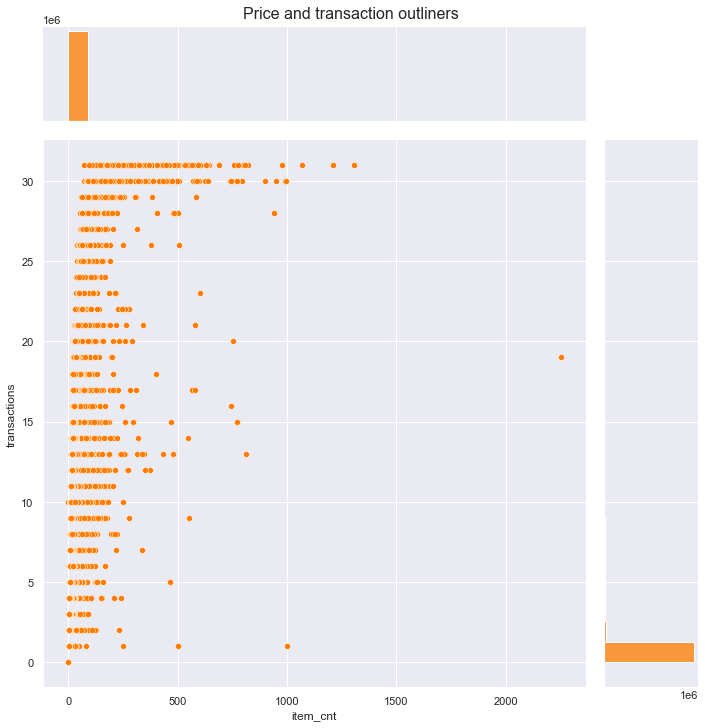

In [26]:
#fig, axes = plt.subplots(2, 2, figsize=(20, 20))
sns.jointplot(x="item_cnt", y="item_price", data=df_train_month_w_missing,height = 10, color = colors[0])
sns.jointplot(x="item_cnt", y="transactions", data=df_train_month_w_missing, height = 10, color = colors[1])
plt.suptitle("Price and transaction outliners", y=1.01, size = 16)
#plt.tight_layout()
plt.show()

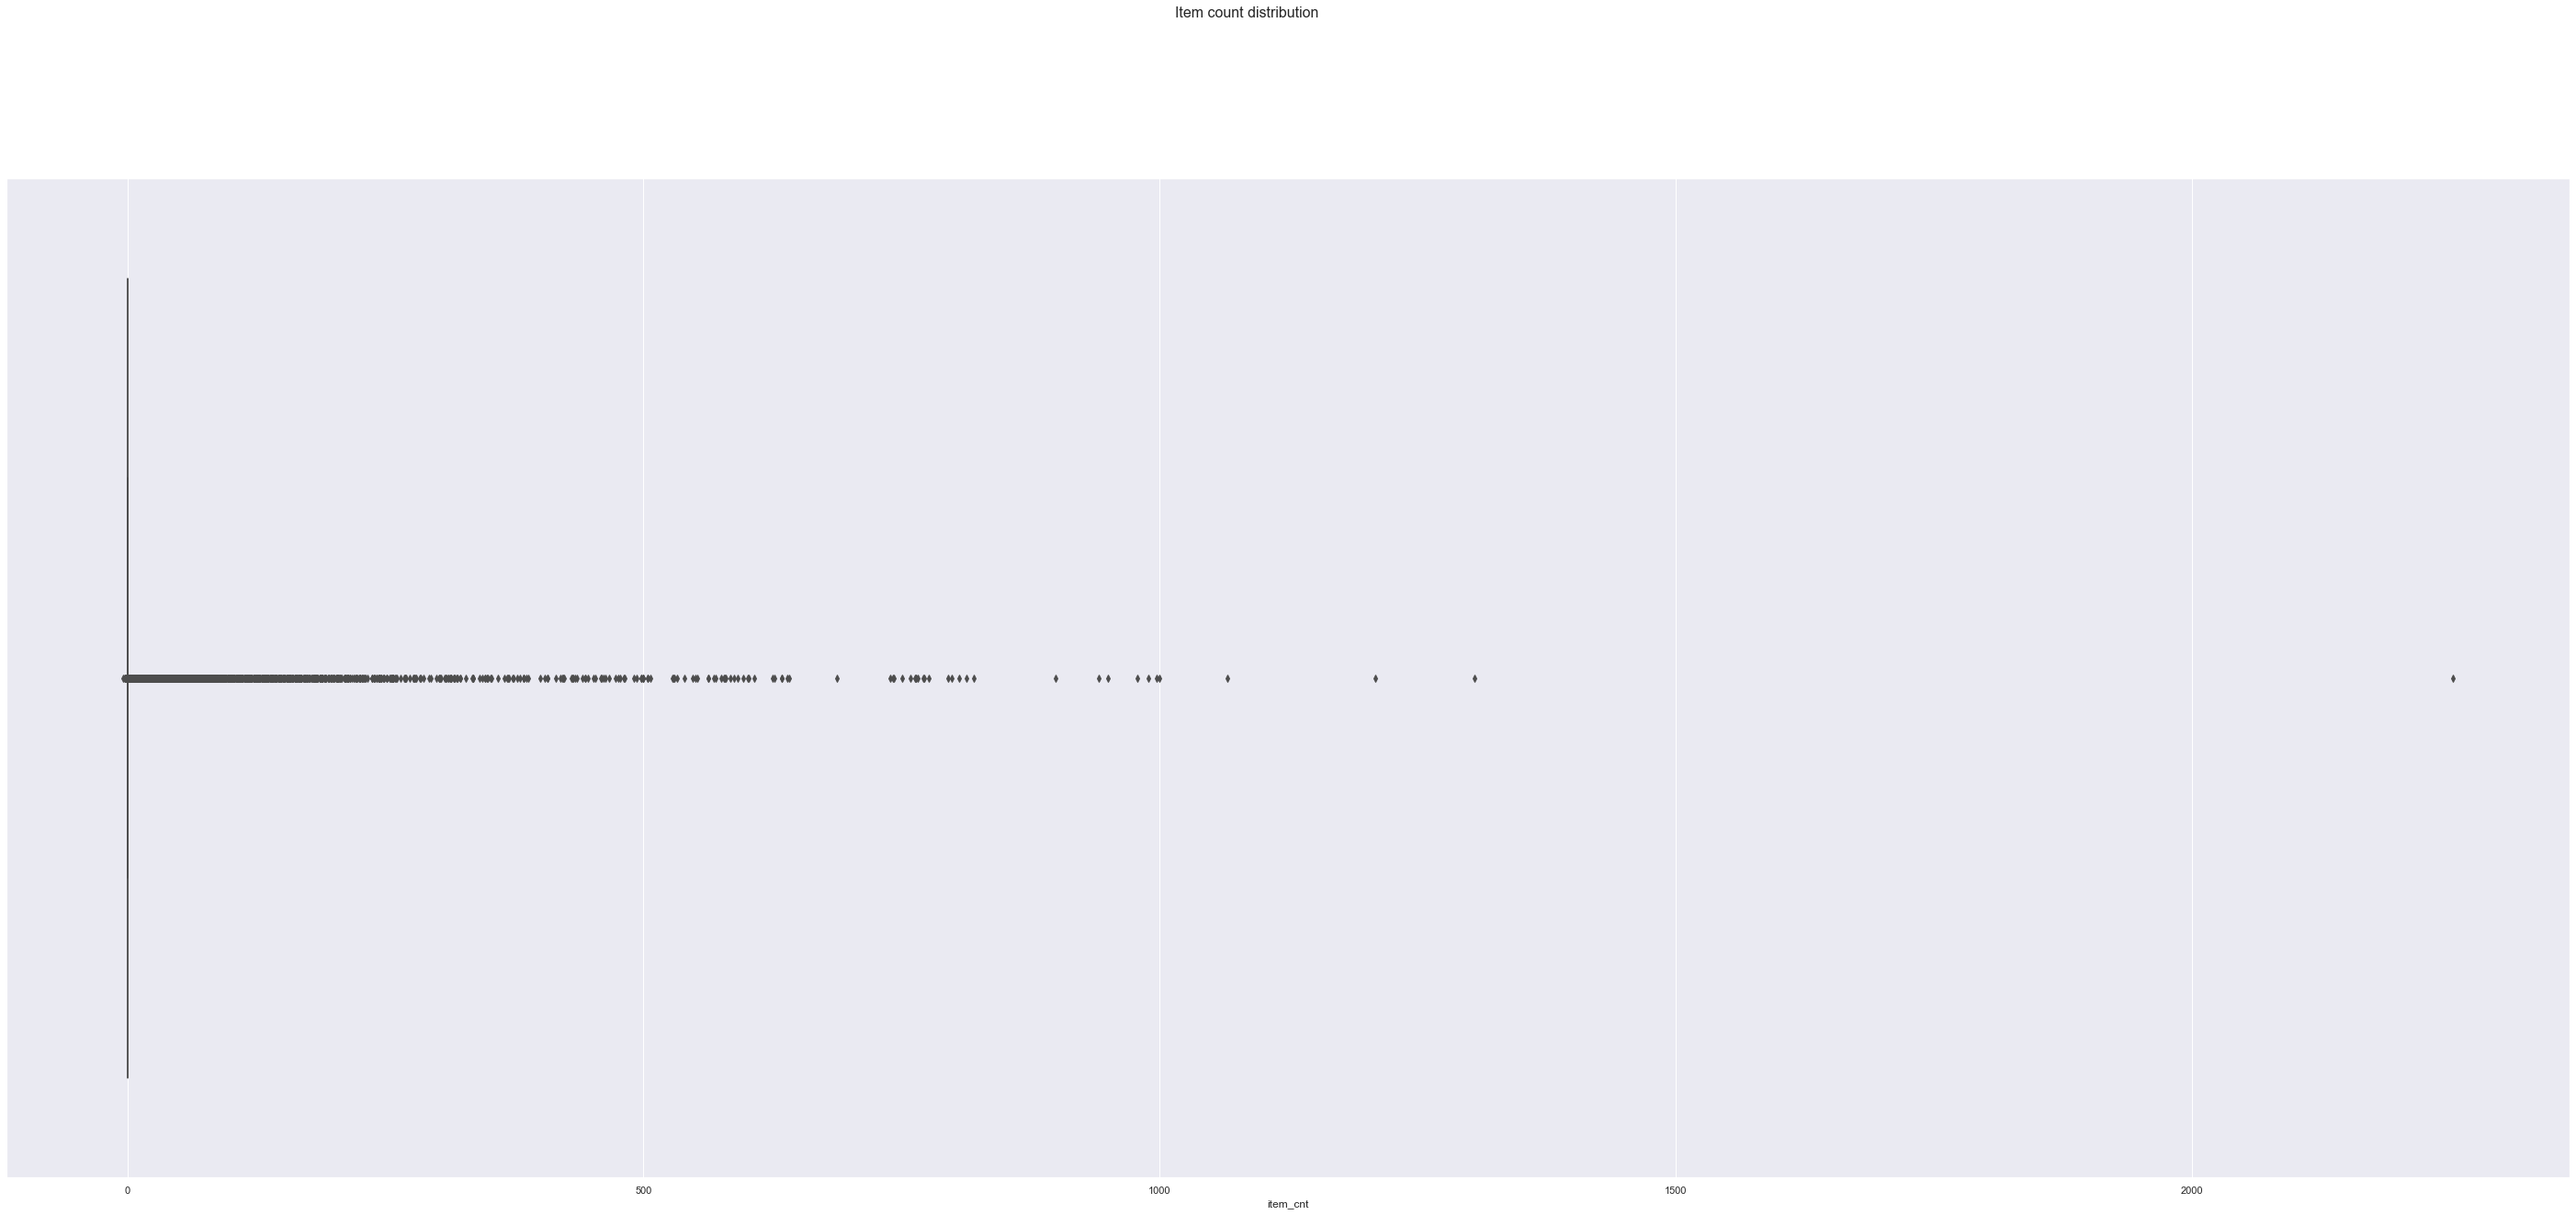

In [27]:
fig, axes = plt.subplots(figsize=(50, 20))
sns.boxplot(df_train_month_w_missing["item_cnt"], color = colors[0])
plt.suptitle("Item count distribution", y=1.01, size = 16)
#plt.tight_layout()
plt.show()

In [28]:
less_item_count = df_train_month_w_missing["item_cnt"][df_train_month_w_missing["item_cnt"] < 100]

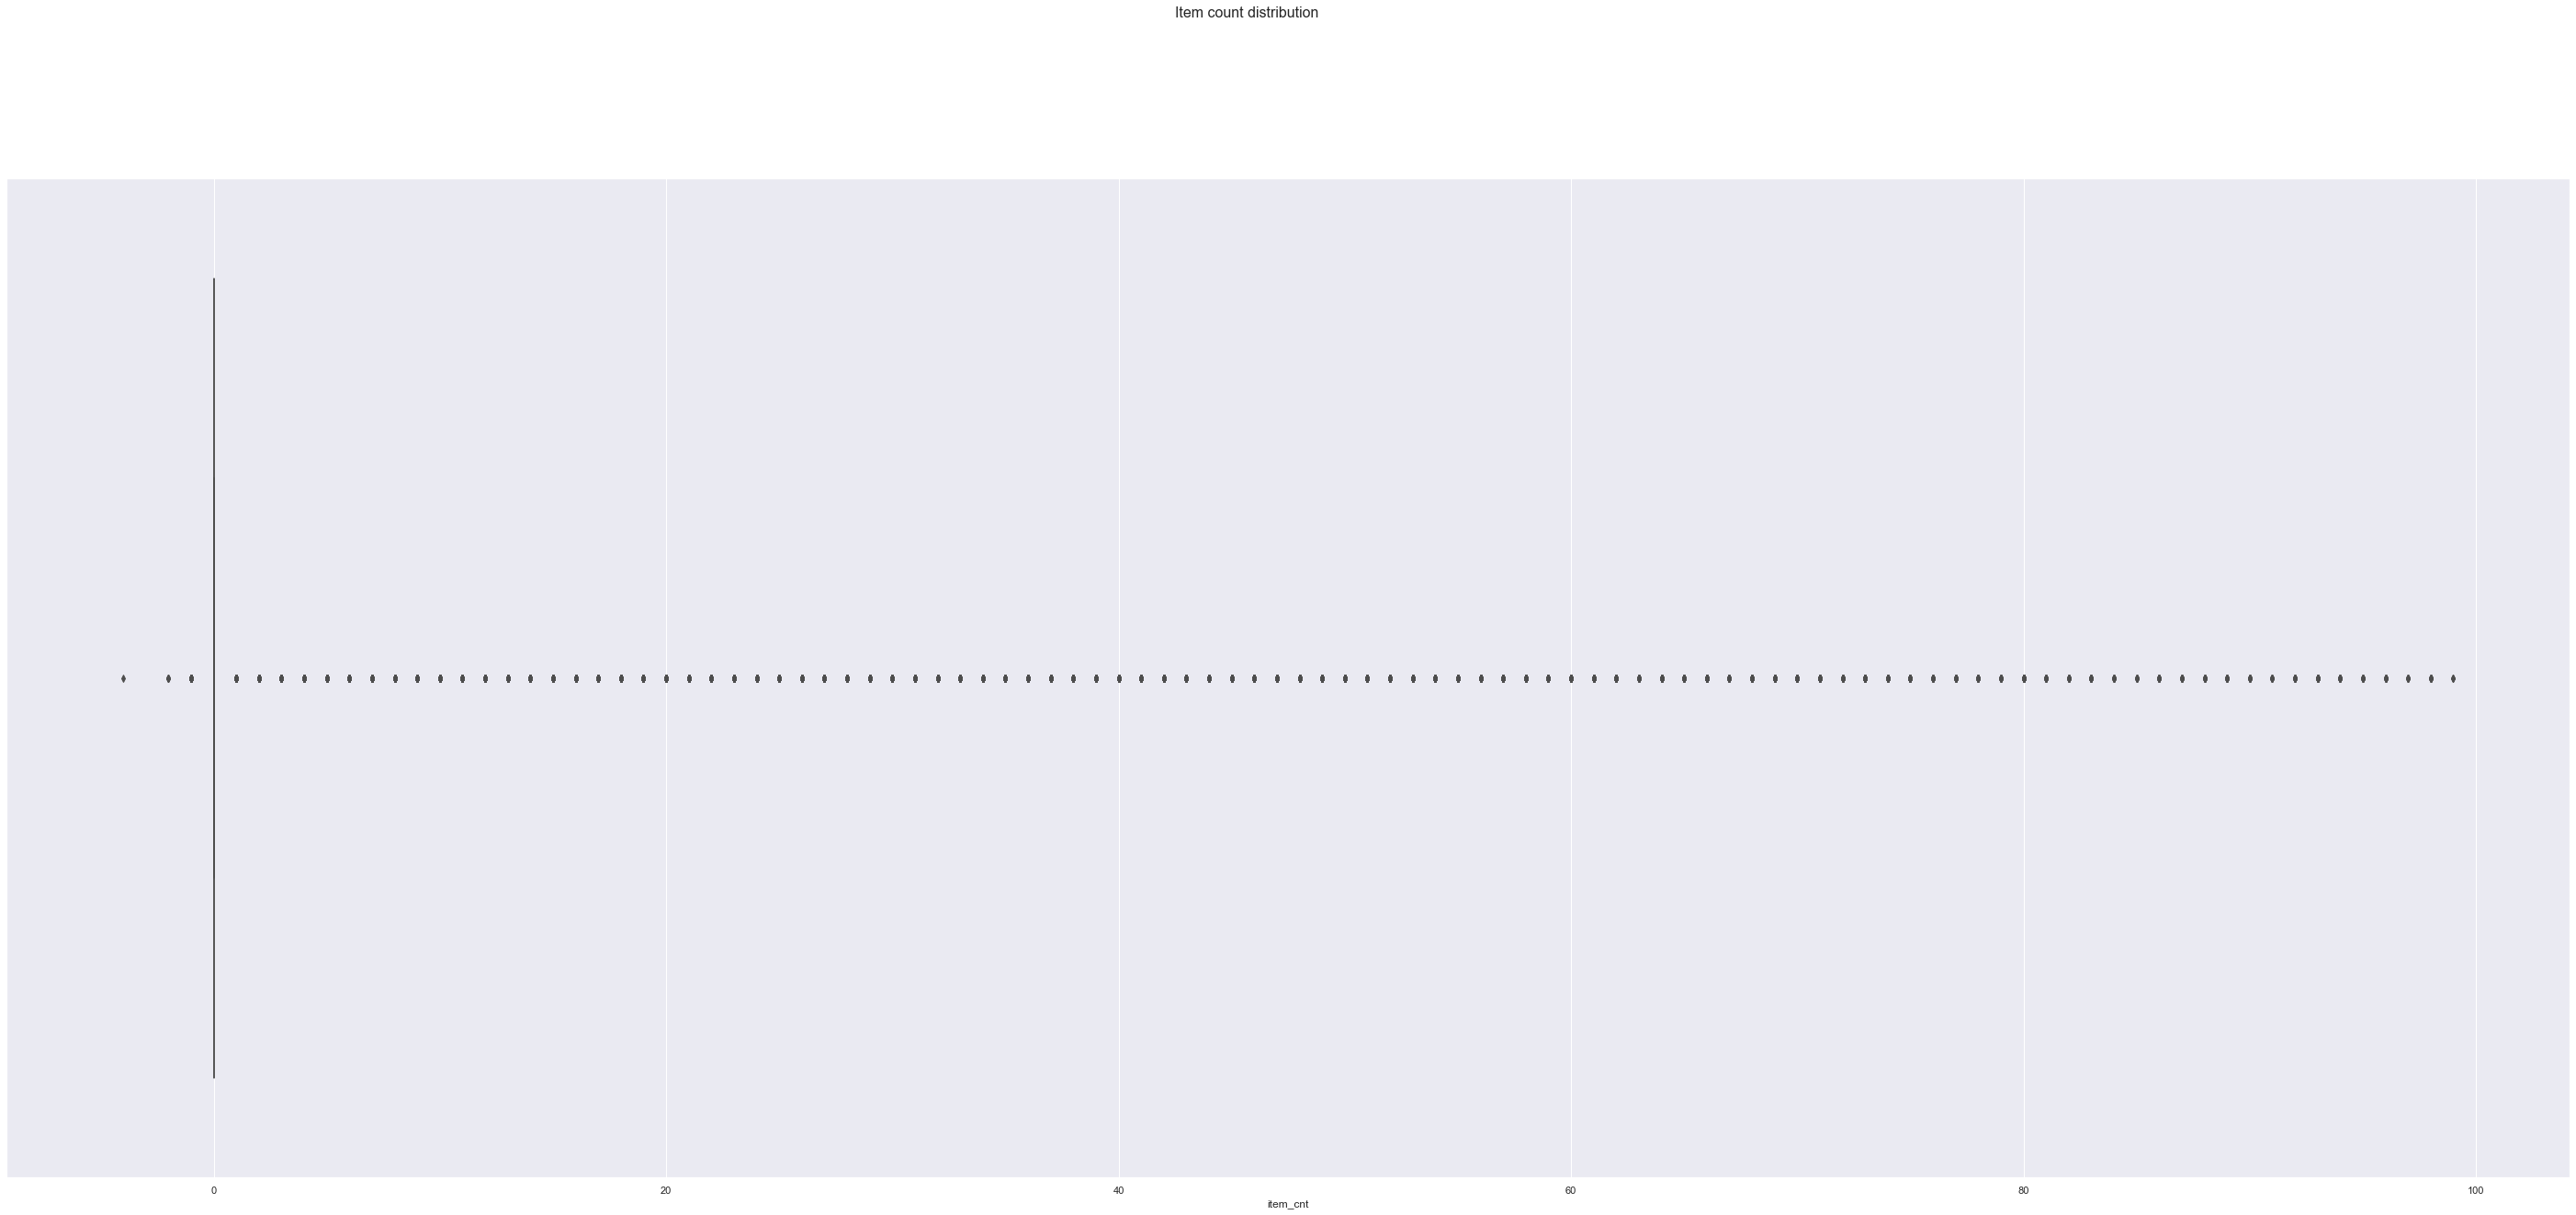

In [29]:
fig, axes = plt.subplots(figsize=(50, 20))
sns.boxplot(less_item_count, color = colors[0])
plt.suptitle("Item count distribution", y=1.01, size = 16)
#plt.tight_layout()
plt.show()

try to leave only >=1 and <= 20, another hypothesis - only 1

In [30]:
df_train_month_w_missing = df_train_month_w_missing.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 350000')

In [31]:
df_train_month_w_missing.head(5)

,month,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,monthly
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0


Feature Engineering

In [32]:
train = df_train_month_w_missing.copy()

In [33]:
train['item_cnt_m'] = train.sort_values('month').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [34]:
train.head(5)

,month,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,monthly,item_cnt_m
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1.00
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0,2.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,2.00


In [35]:
train['item_price_unit'] = train['item_price'] // train['item_cnt']
train['item_price_unit'].fillna(0, inplace=True)

In [36]:
g_item_price = train.sort_values('month').groupby(['item_id'], as_index = False).agg({'item_price' : [np.min, np.max]})
g_item_price.columns = ['item_id', 'hist_min_ip', 'hist_max_ip']

train = pd.merge(train, g_item_price, on = 'item_id', how = 'left')

In [37]:
train.head(10)

,month,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,monthly,item_cnt_m,item_price_unit,hist_min_ip,hist_max_ip
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1.00,1192.00,0.00,18979.50
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0,0.00,inf,0.00,35260.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00,594.00,0.00,5592.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0,2.00,1990.00,0.00,27950.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,2.00,1490.00,0.00,25880.00
5,0,2,7895,6.00,2697.00,899.00,4.00,1.33,3.00,2013,0,1.00,674.00,0.00,8447.00
6,0,2,7956,6.00,13780.00,6890.00,2.00,1.00,2.00,2013,0,0.00,6890.00,0.00,35230.00
7,0,2,1409,19.00,1398.50,1398.50,1.00,1.00,1.00,2013,0,0.00,1398.00,0.00,5596.00
8,0,2,1467,19.00,899.00,899.00,1.00,1.00,1.00,2013,0,0.00,899.00,0.00,5994.00
9,0,2,3076,19.00,1399.00,1399.00,1.00,1.00,1.00,2013,0,3.00,1399.00,0.00,12559.76


In [38]:
train['price_increase'] = train['item_price'] - train['hist_min_ip']
train['price_decrease'] = train['hist_max_ip'] - train['item_price']


In [39]:
train.head(5)

,month,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,monthly,item_cnt_m,item_price_unit,hist_min_ip,hist_max_ip,price_increase,price_decrease
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1.00,1192.00,0.00,18979.50,10730.00,8249.50
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0,0.00,inf,0.00,35260.00,4775.21,30484.79
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00,594.00,0.00,5592.00,1188.30,4403.70
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0,2.00,1990.00,0.00,27950.00,5970.00,21980.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,2.00,1490.00,0.00,25880.00,1490.00,24390.00


rolling window based features

In [40]:
f_min = lambda x: x.rolling(window=3, min_periods=1).min()

f_max = lambda x: x.rolling(window=3, min_periods=1).max()

f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()

f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train[('item_cnt_%s' % function_name[i])] = train.sort_values('month').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

train['item_cnt_std'].fillna(0, inplace=True)

In [41]:
train['item_cnt_max'].value_counts()

0.00     6134452
1.00      226595
2.00      150004
3.00       72565
4.00       41343
5.00       26386
6.00       18029
7.00       12263
8.00        9485
9.00        6946
10.00       5651
11.00       4350
12.00       3615
13.00       3198
14.00       2573
15.00       2337
16.00       1995
17.00       1903
18.00       1589
19.00       1526
20.00       1311
Name: item_cnt_max, dtype: int64

In [42]:
train.head(5)

,month,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,item_cnt_m,item_price_unit,hist_min_ip,hist_max_ip,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,...,1.00,1192.00,0.00,18979.50,10730.00,8249.50,9.00,9.00,9.00,0.00
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,...,0.00,inf,0.00,35260.00,4775.21,30484.79,0.00,0.00,0.00,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,...,1.00,594.00,0.00,5592.00,1188.30,4403.70,2.00,2.00,2.00,0.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,...,2.00,1990.00,0.00,27950.00,5970.00,21980.00,3.00,3.00,3.00,0.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,...,2.00,1490.00,0.00,25880.00,1490.00,24390.00,1.00,1.00,1.00,0.00


In [43]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train[ft_name] = train.sort_values('month').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    train[ft_name].fillna(0, inplace=True)

In [44]:
train['item_cnt_shifted1'].value_counts()

0.00     6246273
1.00      270167
2.00       95605
3.00       42072
4.00       22839
5.00       14243
6.00        9398
7.00        6317
8.00        4793
9.00        3409
10.00       2716
11.00       2013
12.00       1653
13.00       1422
14.00       1109
15.00        965
16.00        797
17.00        734
18.00        598
19.00        547
20.00        446
Name: item_cnt_shifted1, dtype: int64

In [45]:
train['item_trend'] = train['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train['item_trend'] -= train[ft_name]

train['item_trend'] /= len(lag_list) + 1

In [46]:
train.head(5)

,month,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,...,10730.00,8249.50,9.00,9.00,9.00,0.00,0.00,0.00,0.00,2.25
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,...,4775.21,30484.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,...,1188.30,4403.70,2.00,2.00,2.00,0.00,0.00,0.00,0.00,0.50
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,...,5970.00,21980.00,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.75
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,...,1490.00,24390.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.25


In [47]:
train.describe()

,month,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
count,6728116.00,6728116.00,6728116.00,6728116.00,6728116.00,6728116.00,6728116.00,6728116.00,6728116.00,6728116.00,...,6728116.00,6728116.00,6728116.00,6728116.00,6728116.00,6728116.00,6728116.00,6728116.00,6728116.00,6728116.00
mean,16.50,31.64,11042.87,3.75,169.69,79.81,0.19,0.09,0.17,2013.94,...,169.69,5445.98,0.14,0.26,0.20,0.07,0.16,0.14,0.13,-0.06
std,9.81,17.56,6209.70,13.16,1786.66,525.43,0.91,0.31,0.74,0.80,...,1786.66,11080.34,0.69,1.25,0.92,0.44,0.88,0.85,0.82,0.44
min,0.00,2.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-12.50
25%,8.00,16.00,5386.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,...,0.00,999.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,16.00,35.00,11266.00,0.00,0.00,0.00,0.00,0.00,0.00,2014.00,...,0.00,2396.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,25.00,47.00,16068.00,0.00,0.00,0.00,0.00,0.00,0.00,2015.00,...,0.00,5490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,33.00,59.00,22167.00,83.00,344850.00,42990.00,20.00,20.00,19.00,2015.00,...,344850.00,344850.00,20.00,20.00,20.00,13.44,20.00,20.00,20.00,5.00


In [48]:
train['month'].value_counts()

3     197999
0     197996
4     197994
7     197971
30    197968
6     197966
1     197964
15    197961
31    197953
5     197947
18    197947
29    197936
12    197931
17    197923
13    197904
25    197901
16    197894
2     197892
26    197888
19    197887
33    197879
20    197879
28    197873
21    197856
32    197845
24    197844
9     197843
14    197843
27    197832
8     197828
10    197819
22    197692
11    197679
23    197582
Name: month, dtype: int64

Splitting dataset

as we need to predict data for 34th month, 33rd will be test one, 28 - 32 will be validation

In [49]:
df_train_set = train.query('month >= 3 and month < 28').copy()
df_valid_set = train.query('month >= 28 and month < 33').copy()
df_test_set = train.query('month== 33').copy()

df_train_set.dropna(subset = ['item_cnt_m'], inplace = True)
df_valid_set.dropna(subset = ['item_cnt_m'], inplace = True)

df_train_set.dropna(inplace = True)
df_valid_set.dropna(inplace = True)

print('Shapes of sets:\ntrain\tvalidation\ttest\n', df_train_set.shape, df_valid_set.shape, df_test_set.shape)

Shapes of sets:
train	validation	test
 (4946783, 25) (989412, 25) (197879, 25)


In [50]:
print('Percentage of complete data:')
print('test: %s (%.f%% of complete data)' % (df_train_set.shape[0], ((df_train_set.shape[0]/train.shape[0])*100)))
print('validation: %s (%.f%% of complete data)' % (df_valid_set.shape[0], ((df_valid_set.shape[0]/train.shape[0])*100)))


Percentage of complete data:
test: 4946783 (74% of complete data)
validation: 989412 (15% of complete data)


In [51]:
# Shop mean encoding.
gp_shop_mean = df_train_set.groupby(['shop_id']).agg({'item_cnt_m': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = df_train_set.groupby(['item_id']).agg({'item_cnt_m': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = df_train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_m': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = df_train_set.groupby(['year']).agg({'item_cnt_m': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = df_train_set.groupby(['monthly']).agg({'item_cnt_m': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Adding meand encoding features to train set.
df_train_set = pd.merge(df_train_set, gp_shop_mean, on=['shop_id'], how='left')
df_train_set = pd.merge(df_train_set, gp_item_mean, on=['item_id'], how='left')
df_train_set = pd.merge(df_train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
df_train_set = pd.merge(df_train_set, gp_year_mean, on=['year'], how='left')
df_train_set = pd.merge(df_train_set, gp_month_mean, on=['monthly'], how='left')
# Add meanding encoding features to validation set.
df_valid_set = pd.merge(df_valid_set, gp_shop_mean, on=['shop_id'], how='left')
df_valid_set = pd.merge(df_valid_set, gp_item_mean, on=['item_id'], how='left')
df_valid_set = pd.merge(df_valid_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
df_valid_set = pd.merge(df_valid_set, gp_year_mean, on=['year'], how='left')
df_valid_set = pd.merge(df_valid_set, gp_month_mean, on=['monthly'], how='left')

In [52]:
X_train = df_train_set.drop(['item_cnt_m', 'month'], axis=1)
Y_train = df_train_set['item_cnt_m'].astype(int)
X_valid = df_valid_set.drop(['item_cnt_m', 'month'], axis=1)
Y_valid = df_valid_set['item_cnt_m'].astype(int)

In [53]:
X_train.head(15)

,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,monthly,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,2,5572,2.00,2980.00,1490.00,2.00,1.00,2.00,2013,3,...,0.58,1.00,1.00,9.00,-2.25,0.10,1.00,0.84,0.14,0.16
1,2,5643,0.00,0.00,0.00,0.00,0.00,0.00,2013,3,...,0.00,0.00,0.00,0.00,0.00,0.10,1.82,1.84,0.14,0.16
2,2,5583,0.00,0.00,0.00,0.00,0.00,0.00,2013,3,...,0.00,0.00,0.00,0.00,0.00,0.10,0.59,0.04,0.14,0.16
3,2,7893,6.00,9350.00,1870.00,5.00,1.00,5.00,2013,3,...,2.08,1.00,2.00,3.00,-0.25,0.10,3.04,3.12,0.14,0.16
4,2,7894,0.00,0.00,0.00,0.00,0.00,0.00,2013,3,...,0.00,0.00,0.00,0.00,0.00,0.10,3.67,1.68,0.14,0.16
5,2,7895,0.00,0.00,0.00,0.00,0.00,0.00,2013,3,...,0.00,0.00,0.00,0.00,0.00,0.10,1.30,1.48,0.14,0.16
6,2,7956,0.00,0.00,0.00,0.00,0.00,0.00,2013,3,...,0.00,0.00,0.00,0.00,0.00,0.10,0.64,0.80,0.14,0.16
7,2,1409,0.00,0.00,0.00,0.00,0.00,0.00,2013,3,...,0.00,0.00,0.00,0.00,0.00,0.10,0.04,0.04,0.14,0.16
8,2,1467,0.00,0.00,0.00,0.00,0.00,0.00,2013,3,...,0.00,0.00,0.00,0.00,0.00,0.10,0.71,0.64,0.14,0.16
9,2,3076,19.00,799.00,799.00,1.00,1.00,1.00,2013,3,...,1.15,1.00,3.00,1.00,-1.00,0.10,2.62,3.92,0.14,0.16


In [54]:
cb_int_features = ['shop_id', 'item_id', 'year', 'monthly']

X_train[cb_int_features] = X_train[cb_int_features].astype('int32')
X_valid[cb_int_features] = X_valid[cb_int_features].astype('int32')

In [55]:
latest_records = pd.concat([df_train_set, df_valid_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(df_test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_m', axis=1, inplace=True)
#X_test[cb_int_features] = X_test[cb_int_features].astype('int32')
X_test = X_test[X_train.columns]

In [56]:
X_test.head(10)

,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,monthly,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,5,5037,19.00,749.50,749.50,1.00,1.00,1.00,2015,8.00,...,1.15,3.00,1.00,1.00,-1.00,0.13,0.70,0.28,0.22,0.17
1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,2015,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,5233,19.00,2997.00,999.00,3.00,1.00,3.00,2015,8.00,...,1.00,1.00,2.00,3.00,-0.75,0.13,0.07,0.12,0.22,0.17
3,5,5232,0.00,0.00,0.00,0.00,0.00,0.00,2015,8.00,...,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.00,0.22,0.17
4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,2015,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,5039,23.00,749.50,749.50,1.00,1.00,1.00,2015,8.00,...,1.15,3.00,1.00,3.00,-1.50,0.13,0.58,0.36,0.22,0.17
6,5,5041,20.00,11497.00,3832.33,3.00,1.00,3.00,2015,8.00,...,0.00,0.00,0.00,0.00,0.75,0.13,0.00,0.00,0.22,0.17
7,5,5046,0.00,0.00,0.00,0.00,0.00,0.00,2015,8.00,...,0.00,0.00,0.00,0.00,0.00,0.13,0.39,0.28,0.22,0.17
8,5,5319,55.00,897.00,299.00,3.00,1.00,3.00,2015,8.00,...,0.58,2.00,3.00,4.00,-1.50,0.13,0.97,0.96,0.22,0.17
9,5,5003,0.00,0.00,0.00,0.00,0.00,0.00,2015,8.00,...,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.00,0.22,0.17


In [57]:
sets = [X_train, X_valid, X_test]

for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median

X_test.fillna(X_test.mean(), inplace=True)           

In [58]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_valid.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [59]:
X_test['shop_id'] = X_test['shop_id'].astype('int32')
X_test['item_id'] = X_test['item_id'].astype('int32')
X_test['year'] = X_test['year'].astype('int32')
X_test['montlhy'] = X_test['monthly'].astype('int32')
X_train['shop_id'] = X_train['shop_id'].astype('int32')
X_train['item_id'] = X_train['item_id'].astype('int32')
X_train['year'] = X_train['year'].astype('int32')
X_train['montlhy'] = X_train['monthly'].astype('int32')
X_valid['shop_id'] = X_valid['shop_id'].astype('int32')
X_valid['item_id'] = X_valid['item_id'].astype('int32')
X_valid['year'] = X_valid['year'].astype('int32')
X_valid['montlhy'] = X_valid['monthly'].astype('int32')

In [60]:
Y_train.head()

0    2
1    5
2    0
3    1
4    0
Name: item_cnt_m, dtype: int64

Models stacking

In [61]:
catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=32,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    eval_set=(X_valid, Y_valid)
)

Learning rate set to 0.295483
0:	learn: 0.8327597	test: 0.8759905	best: 0.8759905 (0)	total: 717ms	remaining: 5m 57s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.8071029226
bestIteration = 8

Shrink model to first 9 iterations.


In [62]:
print('Model HP:', catboost_model.get_params())

Model HP: {'iterations': 500, 'depth': 4, 'loss_function': 'RMSE', 'od_wait': 25, 'od_type': 'Iter', 'random_seed': 32, 'verbose': 50, 'max_ctr_complexity': 4}


Catboost FI

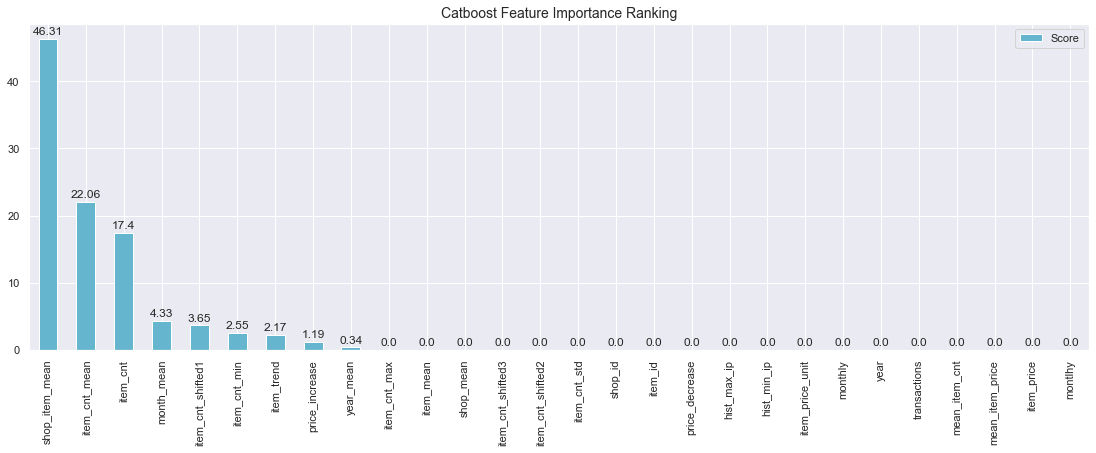

In [63]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [64]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_valid)
catboost_test_pred = catboost_model.predict(X_test)

In [65]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, catboost_val_pred)))

Train rmse: 0.6791356874917862
Validation rmse: 0.8071029226117239


In [66]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
    
# model_performance_sc_plot(catboost_train_pred, Y_train, 'Train')
#model_performance_sc_plot(catboost_val_pred, Y_valid, 'Validation')

In [67]:
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_valid[xgb_features]
xgb_test = X_test[xgb_features]

In [68]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_valid)], 
              verbose=20, 
              early_stopping_rounds=20)

[0]	validation_0-rmse:0.84431	validation_1-rmse:0.88252
[20]	validation_0-rmse:0.67743	validation_1-rmse:0.82761
[25]	validation_0-rmse:0.67712	validation_1-rmse:0.82750


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1000, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.7, tree_method='approx', validate_parameters=1,
             verbosity=None)

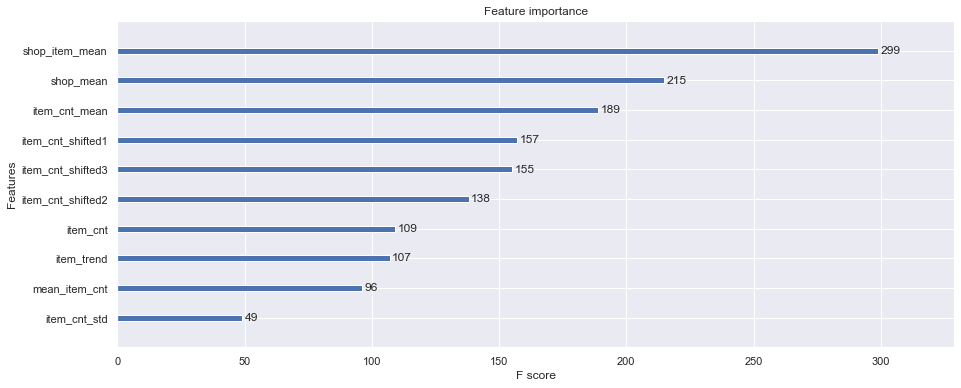

In [69]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [70]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [71]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, xgb_val_pred)))

Train rmse: 0.6874769280113703
Validation rmse: 0.8144288331747741


In [72]:
#model_performance_sc_plot(xgb_val_pred, Y_valid, 'Validation')

In [73]:
# Use only part of features on random forest.
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_valid[rf_features]
rf_test = X_test[rf_features]

In [74]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [75]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [76]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, rf_val_pred)))

Train rmse: 0.6985230747647886
Validation rmse: 0.7760539965122069


In [77]:
# model_performance_sc_plot(rf_train_pred, Y_train, 'Train')
#model_performance_sc_plot(rf_val_pred, Y_valid, 'Validation')

In [78]:
# Use only part of features on linear Regression.
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_valid[lr_features]
lr_test = X_test[lr_features]

In [79]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [80]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(n_jobs=-1)

In [81]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [82]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lr_val_pred)))

Train rmse: 0.7346695766065385
Validation rmse: 0.77552407525084


In [83]:
# model_performance_sc_plot(lr_train_pred, Y_train, 'Train')
#model_performance_sc_plot(lr_val_pred, Y_valid, 'Validation')

In [84]:
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_valid[knn_features]
knn_test = X_test[knn_features]

In [85]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [86]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(leaf_size=13, n_jobs=-1, n_neighbors=9)

In [87]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [88]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, knn_val_pred)))

Train rmse: 0.48661681632052745
Validation rmse: 0.8003541889345014


In [89]:
# model_performance_sc_plot(knn_train_pred, Y_train_sampled, 'Train')
#model_performance_sc_plot(knn_val_pred, Y_validation, 'Validation')

Creating dataset with preds from models to prepare stacking

In [90]:
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_valid.values
first_level.head(20)

,catboost,xgbm,random_forest,linear_regression,knn,label
0,0.77,0.82,0.61,0.60,1.00,0
1,0.88,0.77,0.56,0.04,0.78,0
2,0.04,0.10,0.22,0.04,0.00,0
3,1.18,0.98,0.93,0.04,0.11,4
4,1.95,1.68,1.63,1.46,0.67,1
5,0.79,0.77,0.45,0.04,0.11,1
6,0.49,0.51,0.22,0.04,0.11,0
7,0.04,0.10,0.06,0.04,0.00,1
8,0.41,0.41,0.22,0.04,0.11,0
9,1.61,2.04,1.15,1.15,2.89,2


In [91]:
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,catboost,xgbm,random_forest,linear_regression,knn
0,0.46,0.35,0.96,0.85,0.89
1,0.04,0.06,0.06,0.06,0.00
2,0.51,0.18,0.86,1.79,1.11
3,0.04,0.06,0.00,0.06,0.00
4,0.04,0.06,0.06,0.06,0.00


In [92]:
meta_model = LinearRegression(n_jobs=-1)

In [93]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_valid)

LinearRegression(n_jobs=-1)

In [94]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [95]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_valid)))

Train rmse: 0.765574742815547


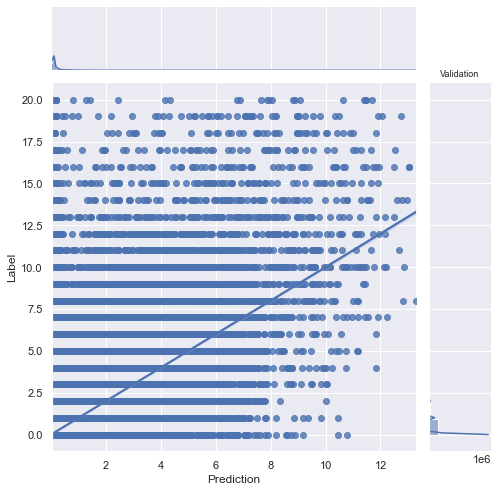

In [96]:
model_performance_sc_plot(ensemble_pred, Y_valid, 'Validation')

In [98]:
prediction_df = pd.DataFrame(df_test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.88
1,1,0.08
2,2,1.30
3,3,0.06
4,4,0.08
5,5,0.96
6,6,1.29
7,7,0.22
8,8,2.03
9,9,0.06
